In [1]:
import json
import pickle
import re
from glob import glob
from tqdm import tqdm
from pdb import set_trace as trace

import regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.metrics import log_loss

In [2]:
def removeZenkakuSpace(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('　', ' ')
    return df

def histEachFavs(df, col, height=3, aspect=4, title=''):
    for fav in sorted(df[FAV].unique()):
        sns.catplot(x=col,data=df.query(f"{FAV} == @fav"),kind='count',height=height, aspect=aspect)
        plt.title(f'{title} fav group:{fav}')
        
def getQueries(df, cols):
    assert type(cols) == str or type(cols) == list, 'cols is str or list'
    queries = []
    if type(cols) == str:
        queries = [f'{cols} == {flag}' for flag in sorted(df[cols].unique())]
    elif type(cols) == list:
        for col in cols:
            col_queries = [f'{col} == {flag}' for flag in sorted(df[col].unique())]
            if len(queries) == 0:
                queries = col_queries
            else:
                queries = [f"{q} & {col_queries[0]}" for q in queries] + [f'{q} & {col_queries[1]}' for q in queries]
            
    return queries

def columnUnique(df, col):
    return sorted(df[col].unique())

def histColumnsFavs(df, cols:list, height=3, aspect=6, title=''):
    queries = getQueries(df, cols)
    for query in queries:
        data = df.query(query)
        if len(data) == 0:
            continue
        sns.catplot(x=FAV,data=data,kind='count',height=height, aspect=aspect)
        plt.title(f'{title} {query}')
        
def histEachFavsByCategory(df, df_target, col):
    cats = sorted(df[col].unique())
    for cat in cats:
        fig, axes = plt.subplots(figsize=(30,10), ncols=3, nrows=2)
        for ax, fav in zip(axes.ravel(), favs):
            target_mask = (df[FAV] == fav) & (df[col] == cat)
            ax.hist(df_target.loc[target_mask], bins=100)
            ax.set_xlim(-1,df_target.max())
            ax.set_title(f'bgenre:{cat}, fav:{fav}, num={target_mask.sum()}')

In [3]:
def featureNumKeywords(df):
    num_keywords = np.vectorize(lambda x: len(x.split()))(df.keyword)
    return pd.DataFrame(data=num_keywords, columns=['num_keywords'])

In [4]:
out_dir = '../output'
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
sub_df = pd.read_csv('../dataset/sample_submission.csv')
ID = 'ncode'
TARGET = 'fav_novel_cnt_bin'
favs = sorted(train_df[TARGET].unique())

# # train_df.userid = train_df.userid.astype('str')
# train_df.genre = train_df.genre.astype('str')
# test_df.userid = test_df.userid.astype('str')
# test_df.genre = test_df.genre.astype('str')
str_cols = ['title', 'story', 'keyword', 'writer']
train_df = removeZenkakuSpace(train_df, str_cols)
test_df = removeZenkakuSpace(test_df, str_cols)

In [5]:
all_df = pd.concat([train_df,test_df])
train_idx = len(train_df)

In [6]:
train_df.columns

Index(['ncode', 'general_firstup', 'title', 'story', 'keyword', 'userid',
       'writer', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 'isr15',
       'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni', 'pc_or_k',
       'fav_novel_cnt_bin'],
      dtype='object')

In [7]:
all_df.keyword = all_df.keyword.fillna('')

In [8]:
import datetime

dt_now = datetime.datetime.now()
all_df['past_days'] = all_df['general_firstup'].apply(lambda x: (dt_now - datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).days)

In [9]:
num_keyword_df = featureNumKeywords(all_df)

In [10]:
len(all_df)

48522

In [11]:
cat_cols = ['userid', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 'isr15', 'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni']

In [12]:
num_cols = ['past_days'] + list(num_keyword_df.columns)

In [13]:
feat_cols = cat_cols + num_cols

In [14]:
def concatDfs(dfs:list):
    concat_df = pd.DataFrame()
#     trace()
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        concat_df = pd.concat([concat_df, df], axis=1)
        
    return concat_df 

In [15]:
concat_df = concatDfs([all_df, num_keyword_df])
display(concat_df.shape)

(48522, 22)

In [16]:
train = concat_df.iloc[:35000, :]
val = concat_df.iloc[35000:train_idx, :]
test = concat_df.iloc[train_idx:, :]
print(train.shape, val.shape, test.shape)

(35000, 22) (5000, 22) (8522, 22)


In [17]:
train_x = train[feat_cols]
train_y = train[TARGET]
val_x = val[feat_cols]
val_y = val[TARGET]
test_x = test[feat_cols]
test_y = test[TARGET]
train_x.shape

(35000, 14)

In [58]:

SEED = 0

params = {
    'objective': 'multiclass',
    'num_classes': 5,
    'metric': 'multi_logloss',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

train_data = lgbm.Dataset(train_x, label=train_y)
val_data = lgbm.Dataset(val_x, label=val_y)

model = lgbm.train(
    params,
    train_data, 
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data], 
    verbose_eval = 100,
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

/home/wsato/work/venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/wsato/work/venv/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['biggenre', 'end', 'genre', 'isbl', 'isgl', 'isr15', 'isstop', 'istenni', 'istensei', 'iszankoku', 'novel_type', 'userid']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/home/wsato/work/venv/lib/python3.8/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/wsato/work/venv/lib/python3.8/site-packages/lightgbm/basic.

Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.929571	valid's multi_logloss: 0.914807
[200]	train's multi_logloss: 0.854514	valid's multi_logloss: 0.856209
[300]	train's multi_logloss: 0.819639	valid's multi_logloss: 0.834726
[400]	train's multi_logloss: 0.799134	valid's multi_logloss: 0.823722
[500]	train's multi_logloss: 0.784835	valid's multi_logloss: 0.818159
[600]	train's multi_logloss: 0.774043	valid's multi_logloss: 0.814739
[700]	train's multi_logloss: 0.765011	valid's multi_logloss: 0.812394
[800]	train's multi_logloss: 0.756964	valid's multi_logloss: 0.810895
[900]	train's multi_logloss: 0.749814	valid's multi_logloss: 0.80985
[1000]	train's multi_logloss: 0.743253	valid's multi_logloss: 0.808942
[1100]	train's multi_logloss: 0.737068	valid's multi_logloss: 0.808255
[1200]	train's multi_logloss: 0.73138	valid's multi_logloss: 0.807809
[1300]	train's multi_logloss: 0.726318	valid's multi_logloss: 0.807589
[1400]	train's multi_loglo

In [59]:
val_pred = model.predict(val_x, num_iteration=model.best_iteration)
val_pred_max = np.argmax(val_pred, axis=1)  # 最尤と判断したクラスの値にする
accuracy = sum(val_y == val_pred_max) / len(val_y)
print(accuracy)

0.6378


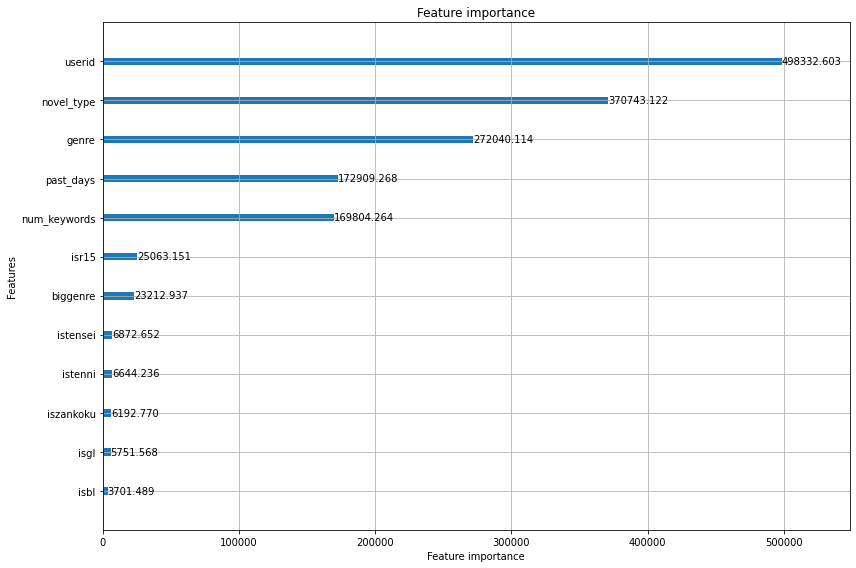

In [61]:
lgbm.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [57]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)
sub_df.iloc[:, 1:] = test_pred
sub_df.to_csv('../output/test_submission.csv', index=False)

In [49]:
sub_df[sub_df.drop('ncode',axis=1).columns]

,proba_0,proba_1,proba_2,proba_3,proba_4
0,0.475381,0.468971,0.048948,0.006068,0.000631
1,0.055693,0.224150,0.531516,0.154298,0.034343
2,0.852964,0.131028,0.011438,0.003921,0.000648
3,0.179715,0.281346,0.211108,0.132911,0.194920
4,0.633833,0.349612,0.015312,0.000886,0.000356
...,...,...,...,...,...
8517,0.525084,0.432783,0.036741,0.005003,0.000389
8518,0.509680,0.457779,0.027716,0.004319,0.000506
8519,0.852964,0.131028,0.011438,0.003921,0.000648
8520,0.850722,0.141046,0.006581,0.001149,0.000502


In [42]:
sub_df

,ncode,proba_0,proba_1,proba_2,proba_3,proba_4
0,N4541HD,0.475381,0.468971,0.048948,0.006068,0.000631
1,N4397HD,0.055693,0.224150,0.531516,0.154298,0.034343
2,N4544HD,0.852964,0.131028,0.011438,0.003921,0.000648
3,N4545HD,0.179715,0.281346,0.211108,0.132911,0.194920
4,N4546HD,0.633833,0.349612,0.015312,0.000886,0.000356
...,...,...,...,...,...,...
8517,N5983HF,0.525084,0.432783,0.036741,0.005003,0.000389
8518,N5990HF,0.509680,0.457779,0.027716,0.004319,0.000506
8519,N5993HF,0.852964,0.131028,0.011438,0.003921,0.000648
8520,N5996HF,0.850722,0.141046,0.006581,0.001149,0.000502
